In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/My Drive/Colab_Files/FMD.zip" -d FMD

Archive:  /content/drive/My Drive/Colab_Files/FMD.zip
   creating: FMD/mask/
   creating: FMD/mask/fabric/
  inflating: FMD/mask/fabric/fabric_moderate_001_new.jpg  
  inflating: FMD/mask/fabric/fabric_moderate_002_new.jpg  
  inflating: FMD/mask/fabric/fabric_moderate_003_new.jpg  
  inflating: FMD/mask/fabric/fabric_moderate_004_new.jpg  
  inflating: FMD/mask/fabric/fabric_moderate_005_new.jpg  
  inflating: FMD/mask/fabric/fabric_moderate_006_new.jpg  
  inflating: FMD/mask/fabric/fabric_moderate_007_new.jpg  
  inflating: FMD/mask/fabric/fabric_moderate_008_new.jpg  
  inflating: FMD/mask/fabric/fabric_moderate_009_new.jpg  
  inflating: FMD/mask/fabric/fabric_moderate_010_new.jpg  
  inflating: FMD/mask/fabric/fabric_moderate_011_new.jpg  
  inflating: FMD/mask/fabric/fabric_moderate_012_new.jpg  
  inflating: FMD/mask/fabric/fabric_moderate_013_new.jpg  
  inflating: FMD/mask/fabric/fabric_moderate_014_new.jpg  
  inflating: FMD/mask/fabric/fabric_moderate_015_new.jpg  
  inflat

In [ ]:
!ls FMD -lah

total 16K
drwxr-xr-x  4 root root 4.0K Nov 16 09:37 .
drwxr-xr-x  1 root root 4.0K Nov 16 09:37 ..
drwxr-xr-x 12 root root 4.0K Nov 20  2009 image
drwxr-xr-x 12 root root 4.0K Jun  8  2010 mask


In [ ]:
!nvidia-smi

Mon Nov 16 09:37:12 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
import pathlib

data_dir = pathlib.Path("FMD/image")

image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

1000


100


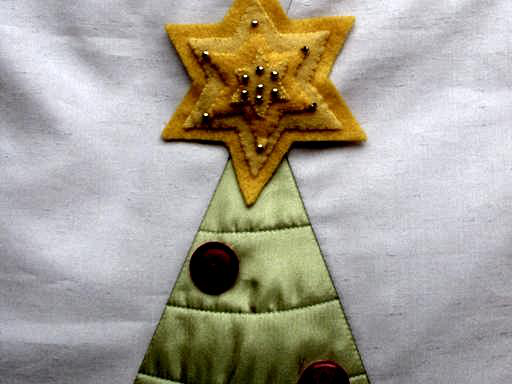

In [ ]:
fabrics = list(data_dir.glob('fabric/*.jpg'))
print(len(fabrics))
PIL.Image.open(str(fabrics[0]))

In [ ]:
batch_size = 16
img_height = 299
img_width = 299

In [ ]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*.jpg'), shuffle=False)
list_ds = list_ds.shuffle(image_count, seed=123, reshuffle_each_iteration=False)

In [ ]:
for f in list_ds.take(5):
  print(f.numpy())

b'FMD/image/foliage/foliage_final_037_new.jpg'
b'FMD/image/water/water_object_036_new.jpg'
b'FMD/image/fabric/fabric_moderate_044_new.jpg'
b'FMD/image/plastic/plastic_object_049_new.jpg'
b'FMD/image/stone/stone_object_013_new.jpg'


In [ ]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['fabric' 'foliage' 'glass' 'leather' 'metal' 'paper' 'plastic' 'stone'
 'water' 'wood']


In [ ]:
# split dataset into 5 equal sized parts for 5-fold cross validation
A = list_ds.shard(num_shards=5, index=0)
B = list_ds.shard(num_shards=5, index=1)
C = list_ds.shard(num_shards=5, index=2)
D = list_ds.shard(num_shards=5, index=3)
E = list_ds.shard(num_shards=5, index=4)

In [ ]:
print(A.cardinality().numpy())
print(B.cardinality().numpy())
print(C.cardinality().numpy())
print(D.cardinality().numpy())
print(E.cardinality().numpy())

200
200
200
200
200


In [ ]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [ ]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

In [ ]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
A = A.map(process_path, num_parallel_calls=AUTOTUNE)
B = B.map(process_path, num_parallel_calls=AUTOTUNE)
C = C.map(process_path, num_parallel_calls=AUTOTUNE)
D = D.map(process_path, num_parallel_calls=AUTOTUNE)
E = E.map(process_path, num_parallel_calls=AUTOTUNE)

In [ ]:
for image, label in A.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (299, 299, 3)
Label:  1


In [ ]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

In [ ]:
ds_fold_dict = {0:A, 1:B, 2:C, 3:D, 4:E}

In [ ]:
preprocess_input = keras.applications.inception_v3.preprocess_input

In [ ]:
base_model = keras.applications.InceptionV3(include_top=False, input_shape=(img_height, img_width, 3))

87916544/87910968 [==============================] - 0s 0us/step


In [ ]:
# don't train base model weights
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
base_learning_rate = 0.0001
def create_model():
  data_augmentation = keras.Sequential(
    [
      layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                  input_shape=(img_height, 
                                                                img_width,
                                                                3)),
      layers.experimental.preprocessing.RandomRotation(0.1),
      layers.experimental.preprocessing.RandomZoom(0.1),
    ]
  )

  global_average_layer = keras.layers.GlobalAveragePooling2D()
  prediction_layer = keras.layers.Dense(10)

  inputs = keras.Input(shape=(img_height, img_width, 3))
  x = data_augmentation(inputs)
  x = preprocess_input(x)
  x = base_model(x, training=False)
  x = global_average_layer(x)
  x = keras.layers.Dropout(0.2)(x)
  outputs = prediction_layer(x)
  model = keras.Model(inputs, outputs)
  optimizer = keras.optimizers.Adam(lr=base_learning_rate)
  loss= keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  model.compile(optimizer=optimizer,
                loss=loss,
                metrics=['accuracy'])
  model.summary()
  return model

In [ ]:
no_epochs = 100

In [ ]:
history_map = {}
base_model_acc_list = []
final_acc_list = []

for i in range(5):
  print('fold', i + 1)
  temp_dict = ds_fold_dict.copy()
  # get test set for this iteration
  current_val_ds = temp_dict[i]

  # get training set for this iteration from remaining data samples
  del temp_dict[i]
  current_train_ds = None
  for ds_shard in temp_dict.values():
    if current_train_ds is None:
      current_train_ds = ds_shard
    else:
      current_train_ds = current_train_ds.concatenate(ds_shard)
  
  current_train_ds = configure_for_performance(current_train_ds)
  current_val_ds = configure_for_performance(current_val_ds)

  # create a new model
  model = create_model()
  # get initial test accuracy
  base_model_acc_list.append(model.evaluate(current_val_ds)[1])
  # train for specified epochs
  history = model.fit(current_train_ds,
                    epochs=no_epochs,
                    validation_data=current_val_ds)
  
  # save results
  if i == 0:
    history_map['accuracy'] = [history.history['accuracy']]
    history_map['val_accuracy'] = [history.history['val_accuracy']]
    history_map['loss'] = [history.history['loss']]
    history_map['val_loss'] = [history.history['val_loss']]
  else:
    history_map['accuracy'].append(history.history['accuracy'])
    history_map['val_accuracy'].append(history.history['val_accuracy'])
    history_map['loss'].append(history.history['loss'])
    history_map['val_loss'].append(history.history['val_loss'])
  
  # get final test accuracy
  final_acc_list.append(model.evaluate(current_val_ds)[1])

fold 1
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 299, 299, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 299, 299, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 299, 299, 3)]     0         
_________________________________________________________________
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)      

In [ ]:
print("Base model accuracy:", np.mean(base_model_acc_list))
print("Final accuracy:", np.mean(final_acc_list))

Base model accuracy: 0.10899999886751174
Final accuracy: 0.8240000009536743


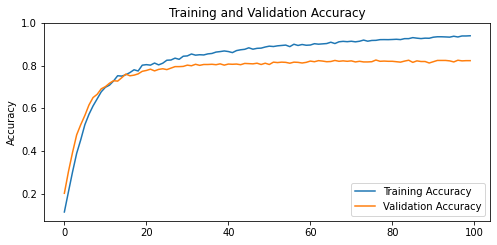

In [ ]:
acc = np.mean(history_map['accuracy'], axis=0)
val_acc = np.mean(history_map['val_accuracy'], axis=0)

plt.figure(1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.savefig('/content/drive/My Drive/Colab_Files/cv_acc.jpg')
plt.show()

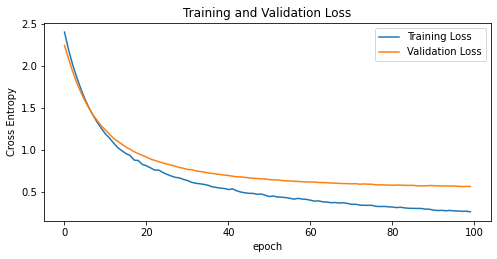

In [ ]:
loss = np.mean(history_map['loss'], axis=0)
val_loss = np.mean(history_map['val_loss'], axis=0)

plt.figure(2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig('/content/drive/My Drive/Colab_Files/cv_loss.jpg')
plt.show()